---
### Import necessary libraries

In [1]:
import sys
import os
import gc
import numpy as np
import pandas as pd 
import tensorflow
import tensorflow.compat.v2 as tf
import warnings
warnings.filterwarnings("ignore")
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/creditCardFraud/AnomalyDetection/scripts/")

In [3]:
from util import *
from NN_util import *
%load_ext autoreload
%autoreload 2

In [4]:
# make sure GPU is running 
tf.test.gpu_device_name()
# set max limit to 7.5 G /8 total available 
set_gpu_limit(7.5)

### Import training and dev data and convert to numpy array for NN 

In [5]:
train = pd.read_csv(f"{home}/Documents/projects/creditCardFraud/processedData/TrainingData_normal.csv")
dev = pd.read_csv(f"{home}/Documents/projects/creditCardFraud/processedData/DevData_normal.csv")

### Converting into tf data set to allow simple efficient data pipelines. 
* In autoencoder, you are predicting the original input x 
* shuffle and train data in batches with 120 epochs 

In [6]:
batch_size = 256
sizes = [20,10]
epochs = 120
input_size = train.shape[1]
encoded_size = 5

In [7]:
train_data, dev_data = make_tensor_dataset([train,dev],batch_size)

### Garbage collect

In [8]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


----
### Set up checkpoint and other settings 

In [9]:
checkpoint = tfk.callbacks.ModelCheckpoint(f"{home}/Documents/Projects/creditCardFraud/savedModels/VariationalEncoderModel_1.h5",verbose=1,save_best_only=True)
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss", mode="min", min_delta=0.005, patience=20, verbose=1, restore_best_weights=True)

### For variational autoencoder we need to maximize ELBO (evidence lower bound objective):

$$ELBO(x)= \int dzq(z|x)logp(x|z) + \int dzq(z|x)log\frac{q(z|x)}{p(z)} $$

* p(z): the prior on the latent representation z (last layer of encoder) 
* q(z|x_input): the encoder (how likely is z given x_input)
* p(x_hat|z): the decoder (how likely is x_hat given z) 
* $\int dzq(z|x)logp(x|z)$: reconstructin term. (how likely for us to get output_x given input_x and encode to z then decode to x_output) 
* $\int dzq(z|x)log\frac{q(z|x)}{p(z)} $: KL divergence. How similar are the encoder distribution and the prior distribution. 

### Prior distribution for z: 

* Since this is latent representation (noise has been removed), it is okay to assume it is isotropic gaussian:

  - standard deviation: 1
  - average: 0 

In [10]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

----
###  Encoder model for autoencoder:
* encoder: 3 layers:
  * 3 dense layers 
  * 3 dimensional multivariable non zero covariance normal distribution

### Decoder model for autoencoder:
* decoder: 3 layers:
   * 3 dense layers
   * independent normal distributions as output 

### Add encoders together 


In [11]:
VAE, encoder, decoder = make_autoencoder(sizes,input_size, ifvae=True,
                                         encoded_size=encoded_size, prior = prior)

In [12]:
VAE.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 10)                830       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 5), (None, 5))    0         
_________________________________________________________________
decoder (Sequential)         (None, 30)                1540      
Total params: 2,590
Trainable params: 2,590
Non-trainable params: 0
_________________________________________________________________


### Define reconstruction loss

In [13]:
negloglik = lambda x_input, x_output: -x_output.log_prob(x_input)

### Compile the model and train model

In [14]:
VAE.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

In [25]:
history = VAE.fit(train_data,epochs=epochs,shuffle=True,
                          verbose=1,validation_data=dev_data,
                          callbacks=[checkpoint,earlystop])

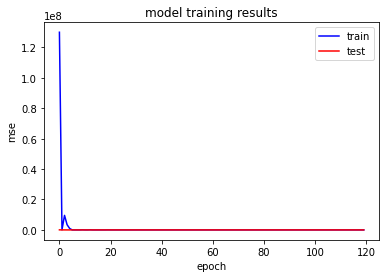

In [16]:
plot_loss(history) 

In [17]:
VAE.load_weights(f"{home}/Documents/projects/creditCardFraud/savedModels/VariationalEncoderModel_3.h5")

### Garbage collect

In [18]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


---


### Create monte carlo to generate output log prob score for anomaly prediction

In [19]:
test = pd.read_csv(f"{home}/Documents/projects/creditCardFraud/processedData/hold_outset_moreFraud.csv")

In [20]:
test_tf_data, label = test.drop("Class",axis=1), test["Class"]

In [21]:
for i in range(5):
    x_log_prob,y_label = reconstruction_log_prob_sampled(test_tf_data,label,1000,encoder,decoder,sampling_size=100)
    results = model_results(y_label,-x_log_prob)
    print("anomaly output")
    print(results[results.label==1].anomaly_prob.describe())
    print("normal output")
    print(results[results.label==0].anomaly_prob.describe())

anomaly output
count      7.000000
mean     104.223091
std       12.516960
min       94.751442
25%       96.507725
50%       98.956169
75%      107.816036
max      127.206589
Name: anomaly_prob, dtype: float64
normal output
count    993.000000
mean      26.017487
std       15.482258
min      -25.719110
25%       16.754934
50%       27.849455
75%       35.844555
max       73.261116
Name: anomaly_prob, dtype: float64
anomaly output
count     12.000000
mean      81.122681
std       33.404808
min       17.607420
25%       69.787399
50%       90.947460
75%       99.572811
max      126.638466
Name: anomaly_prob, dtype: float64
normal output
count    988.000000
mean      26.298513
std       16.530684
min      -28.513996
25%       17.022958
50%       27.499883
75%       36.492791
max      111.831207
Name: anomaly_prob, dtype: float64
anomaly output
count      7.000000
mean      93.836906
std       35.434513
min       37.065933
25%       76.719105
50%       98.955109
75%      115.824661
max    

### This gives a rough idea on where the threshold should be set 

### Let's look at precision recall curve

In [22]:
x_log_prob = reconstruction_log_prob(test_tf_data.values,1000,encoder,decoder)

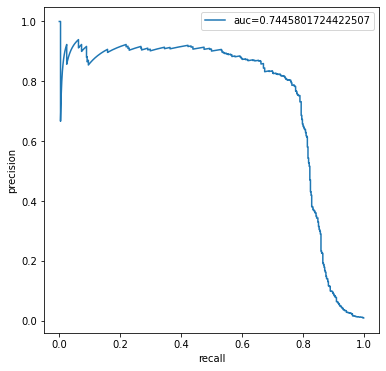

In [23]:
plot_pr_re(label,-x_log_prob)

### Choose a threshold that gives a good overall class1 recall 
  * ~ 75% quantile value for abnormal returns 

In [24]:
output = model_results(label,-x_log_prob,75,ifprint=True)

[[56748   110]
 [  110   382]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56858
           1       0.78      0.78      0.78       492

    accuracy                           1.00     57350
   macro avg       0.89      0.89      0.89     57350
weighted avg       1.00      1.00      1.00     57350



### More epoch with more latent representation and more data will certainly improve the outcome. 
-----